# Introduction

This jupyter notebook file presents my data analytics workflow. To predict an outcome variable (churn) I am using 5 different models: logistic regression, decision trees, SVM, an ensemble method based on all three, and random forests. The purpose of this file is to show how I would approach a data analytics problem. In short, this file follows these steps:

1. Getting the data from the SQL database
2. Cleaning and preparing the dataset (+ creating a data cleaning pipeline)
3. Predicting an outcome variable using the 5 different models
4. Arguing for a winning model and estimating the value impact in USD

### Background of the dataset and case
Toy Storey sells toys online and offers shipping or pick-up globally. They offer a subscription service (a surprise box of toys delivered at home every month). Throughout the last six year, ten percent of customers have been invited to try for a free first month. Offering the first month, including approaching customers and setting up the service package, is quite costly 40\\$). All consumers that are approached, subscribe to the service. For those customers who retain their service contract, the subscription program is very profitable (20$ margin per month, starting second month).

*Here my task is to harness business value based on the subscription service*

**My approach is**
- First, based on the customers who were chosen for the subscription service (10% of all the ToyStorey customers) estimate the revenue of a customer who **did not churn** and the revenue of a customer who **churned**. Compare the two.
- Predict a customers probability of churning from the subscription service.
- Offer an incentive to the customer to avoid churning. Calculate revenue per customer if the incentive is offered. Determine the cost of the incentive.

**Executive summary**
1. According to our training set (the customers that were chosen for the subscription program) the revenue generated by customers **who did not churn** was 693\\$ and for customers **who churned** was 294$. Therefore, for every customer we can retain, we expect to make 399\\$ (693-294) more in total. Assuming marginal cost of 40 USD and marginal revenue of 60 USD and first month free.

2. The best model predicts 64% of churners. Thus, the expected revenue gained from retaining a customer is around (399 X 0.64) ~ 250 USD. However, these figures are accurate if we have a 100% success rate with the predicted churners and 0 retention costs.

3. We are thinking that offering a 3 month 50% discount could be a reasonable effort and half of all these who receive it will retain. Therefore, we expect to spend 30 USD more per customer and retain half, bringing our total profit to (250) X 0.5 - 30 = 95 USD. Well worth our efforts. The incentive structure can be debated (i.e. how many months and how much % of discount).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy

# set standard figure size to bigger:
plt.rcParams['figure.figsize'] = [15, 10]

## 1. Getting the Data from the database

In [ ]:
# The string that sqlalchemy takes: mysql+pymysql:// + username: + password: + host: + port/ + database
engine = sqlalchemy.create_engine('mysql+pymysql://__________+____________+_____+_____/+__________')
# I removed the database information due to the file being public and wanting to prevent unwanted queries

From the SQL database related to the customers that were chosen to the subscription service (10% of all ToyStorey customers), I am interested in these variables:

1. **customer_id (integer)** - A customers ID
2. **tenure (integer)** - Total months subscribed to service, first month is 0
3. **contract (categorical)** - Type of contract: rolling, 1 year or 2 years
4. **payment_method (categorical)** - Method of payment: Credit, Debit or Invoice
5. **total_orders (integer)** - Total number of orders by a customer
6. **spend (float)** - How much a user spent in total for products
7. **category (integer)** - Number of products from the 'Figures & Playsets' category
8. **discount_1 (boolean)** - 1 if customer used the discount code 'HJD&G6D33W'
9. **discount_2 (boolean)** - 1 if customer used the discount code 'MA20GIC'
10. **churn (boolean)** - Is 1 if customer has cancelled subscription, otherwise 0
11. **pop_cat_buys (integer)** - Number of products bought in the 10 most popular categories

In [ ]:
query = '''
SELECT customer_id, tenure, contract, payment_method,
COUNT(customer_id) AS total_orders,
SUM(IFNULL(price, 0)) AS spend,
SUM(IF(SUBSTRING_INDEX(category, '>', 1) = 'Figures & Playsets', 1, 0)) AS category,
SUM(IF(discount_code = 'HJD&G6D33W', 1, 0)) AS discount_1,
SUM(IF(discount_code = 'MA20GIC', 1, 0)) AS discount_2, churn

FROM Subscription
LEFT JOIN Receipt USING (customer_id)
LEFT JOIN ReceiptProduct USING (receipt_id)
LEFT JOIN Product USING (product_id)

GROUP BY customer_id
'''

df = pd.read_sql_query(query, engine)

In [ ]:
# Here I am using inner join to get the purchases in the top categories.

query2 = '''
SELECT customer_id, COUNT(customer_id) AS pop_cat_buys
FROM Subscription s2 
LEFT JOIN Receipt r1 USING (customer_id)
LEFT JOIN ReceiptProduct rp1 USING (receipt_id)
LEFT JOIN Product p1 USING (product_id)
WHERE category IN 
(
	SELECT category
	FROM Subscription s 
	LEFT JOIN Receipt r USING (customer_id)
	LEFT JOIN ReceiptProduct rp USING (receipt_id)
	LEFT JOIN Product p USING (product_id)
	GROUP BY category
	HAVING COUNT(category) > 500
)
GROUP BY customer_id
'''

cat = pd.read_sql_query(query2, engine)

## 2. Preparing the dataset

In [ ]:
# Merge the 2 downloaded dataframes:
df = pd.merge(df, cat, how='outer', on = ['customer_id']).fillna(0)

# Save the dataset
df.to_csv('toy_storey_modelling.csv', index = False)

In [ ]:
# Load up the dataset:
df = pd.read_csv('toy_storey_modelling.csv')

In [4]:
df.head()

,customer_id,tenure,contract,payment_method,total_orders,spend,category,discount_1,discount_2,churn,pop_cat_buys
0,122834523526,1,Month-to-month,Electronic check,6,178.12,2.0,0.0,0.0,No,2.0
1,153789115761,71,Two year,Bank transfer (automatic),1,2.96,0.0,0.0,0.0,No,0.0
2,222107859862,71,Two year,Credit card (automatic),2,5.71,0.0,0.0,0.0,No,0.0
3,238307148688,1,Month-to-month,Bank transfer (automatic),2,12.28,0.0,0.0,0.0,Yes,1.0
4,264312102375,72,Two year,Credit card (automatic),4,40.98,1.0,0.0,0.0,No,0.0


In [5]:
np.mean(df.tenure)

32.37114865824223

### Basic preparation

In [6]:
# Convert churn to a binary variable:
df.churn = df.churn.eq('Yes').mul(1).astype('uint8')

# Drop the customer_id column
df = df.drop("customer_id", axis = 1)

In [7]:
from sklearn.model_selection import train_test_split

# Split the test and train sets:
X_train, X_test = train_test_split(df, test_size = 0.3, random_state = 42)

# Separate the labels from the datasets:
y_train = X_train["churn"].copy()
X_train = X_train.drop("churn", axis = 1)

y_test = X_test["churn"].copy()
X_test = X_test.drop("churn", axis = 1)

### Transform Column variables

In [8]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

cat_attribs = ['contract', 'payment_method']         # Names of categorical attributes
num_attribs = list(X_train.drop(cat_attribs, axis = 1))   # Names of numerical attributes

In [9]:
# Define a custom column transformer where I create 2 more explanatory variables:
# 1) Total amount spent per 1 product; 2) Toys bought in a popular category per total toys bought

from sklearn.base import BaseEstimator, TransformerMixin

total_orders, spend, pop_cat_buys = 1, 2, 6 # location in the (numeric attributes) dataset

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        return None

    def fit(self, X, y = None):
        return self

    def transform(self, X):
        spend_per_product = X[:, spend] / X[:, total_orders]
        pop_cat_buys_per_total = X[:, pop_cat_buys] / X[:, total_orders]
        
        return np.c_[X, spend_per_product, pop_cat_buys_per_total]
    
extra_attribs = ['spend_per_product', 'pop_cat_buys_per_total']

In [10]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),  # Replace missing values with the median value 
    ('attributes_adder', CombinedAttributesAdder()),  # Create new attributes and add them to the dataset
    ('std_scaler', StandardScaler())                  # Feature normalization
])

In [11]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),    # Apply the numeric pipeline to numeric variables
    ("cat", OneHotEncoder(), cat_attribs)  # Apply one hot encoding to categorical variables
])

X_prep = full_pipeline.fit_transform(X_train)

The resulting dataframe will include the following **explanatory variables**:
1. tenure
2. contract	(one hot encoded, 3 separate variables) - 
3. payment_method (one hot encoded, 4 separate variables)
4. total_orders	
5. spend
6. category
7. discount_1
8. discount_2 
9. pop_cat_buys (number of product purchases in the 10 most popular categories)
10. spend_per_product
11. pop_cat_buys_per_total

In total, we have 11 - 2 (contract and payment_method) + 7 (OHE variables) = **16**

In [12]:
X_prep.shape

(4930, 16)

## 3. Training models

### 1) Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
log_reg = LogisticRegression() # default solver lbfgs

In [15]:
log_model = log_reg.fit(X_prep, y_train)

In [16]:
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, cohen_kappa_score

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn/(tn + fp)
    return specificity

def accuracy_table(threshold, model, X_train, y_train):
    predictions = np.where(model.predict_proba(X_train)[:,1] > threshold, 1, 0)
    
    return pd.DataFrame(data = [accuracy_score(y_train, predictions), recall_score(y_train, predictions),
                    specificity_score(y_train, predictions), cohen_kappa_score(y_train, predictions)], 
                        index = ['Accuracy', 'Recall', 'Specificity', 'Kappa'])

In [17]:
print("Logistic Regressin performance on the training set:")
accuracy_table(0.5, log_model, X_prep, y_train)

Logistic Regressin performance on the training set:


,0
Accuracy,0.774037
Recall,0.433486
Specificity,0.897018
Kappa,0.363141


In [18]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(log_model, X_prep, y_train,
                        scoring = "accuracy", cv = 10)

In [19]:
def display_scores(scores):
    print("Scores:", scores)
    print('\033[1m' + "Mean Accuracy: " +  str(scores.mean()) + '\033[0m')
    print("Standard Deviation:", scores.std())
    
display_scores(scores)

Scores: [0.78093306 0.75862069 0.77079108 0.75862069 0.76064909 0.76673428
 0.77890467 0.831643   0.7464503  0.77890467]
Mean Accuracy: 0.7732251521298175
Standard Deviation: 0.02210488069099437


### 2) Decision Tree classifier

In [20]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier()

In [21]:
tree_model = tree_clf.fit(X_prep, y_train)
accuracy_table(0.5, tree_model, X_prep, y_train)

,0
Accuracy,0.988844
Recall,0.960245
Specificity,0.999172
Kappa,0.971036


The Decision Tree Classifier is badly overfitting the dataset. This calls for some cross validation in order to find a better measure for the accuracy metric.

In [22]:
scores = cross_val_score(tree_clf, X_prep, y_train,
                        scoring = "accuracy", cv = 10)

display_scores(scores)

Scores: [0.71805274 0.71196755 0.71805274 0.71399594 0.7525355  0.73225152
 0.69574037 0.73022312 0.72819473 0.72210953]
Mean Accuracy: 0.7223123732251521
Standard Deviation: 0.01424073778374692


As we can see, the accuracy from the decision tree model is even lower than the logistic regression accuracy. I will try to regularize the model in order to reduce overfitting. I will restrict the model by setting a minimum number of sample leaves (10) a node must have so that the tree won't end up with too many nodes. On the other hand, it now becomes quite hard to plot and make sense of the decision tree and it still fails to beat logistic regression on accuracy.

In [23]:
tree_clf = DecisionTreeClassifier(min_samples_leaf = 10)

scores = cross_val_score(tree_clf, X_prep, y_train,
                        scoring = "accuracy", cv = 10)

display_scores(scores)

Scores: [0.76673428 0.76673428 0.76470588 0.77079108 0.74036511 0.75659229
 0.76064909 0.79918864 0.75456389 0.74036511]
Mean Accuracy: 0.7620689655172413
Standard Deviation: 0.015921305844373554


In [24]:
tree_model = tree_clf.fit(X_prep, y_train)
print("Decision Tree Classifier performance on the training set:")
accuracy_table(0.5, tree_model, X_prep, y_train)

Decision Tree Classifier performance on the training set:


,0
Accuracy,0.840568
Recall,0.612385
Specificity,0.922971
Kappa,0.566923


### 3) SVM Classifier

In [25]:
from sklearn.svm import SVC

In [26]:
svm_clf = SVC(probability = True) # default Kernel is the RBF Kernel

In [27]:
svm_fit = svm_clf.fit(X_prep, y_train)
accuracy_table(0.5, svm_fit, X_prep, y_train)

,0
Accuracy,0.781136
Recall,0.382263
Specificity,0.925179
Kappa,0.353848


This model has decent accuracy and does not seem to overfit as shown below with the cross validation example.

In [28]:
scores = cross_val_score(svm_fit, X_prep, y_train,
                        scoring = "accuracy", cv = 5)

display_scores(scores)

Scores: [0.77484787 0.76064909 0.75557809 0.80831643 0.76470588]
Mean Accuracy: 0.7728194726166329
Standard Deviation: 0.018843365780922668


But, I think I can do better by tweaking hyperparameters gamma and C for the SVC with the RBF Kernel. I will use grid search to find the best combination for gamma and C.

In [27]:
from sklearn.model_selection import GridSearchCV

svm_clf = SVC(probability = True)

param_grid = [
    {'gamma': [0.1, 1, 10], 'C': [0.1, 1, 10, 100]}
]

grid_search = GridSearchCV(svm_clf, param_grid, cv = 5,
                          scoring = 'accuracy',
                          return_train_score = True)

In [28]:
grid_search.fit(X_prep, y_train)
grid_search.best_params_

{'C': 1, 'gamma': 1}

In [29]:
svm_clf2 = SVC(probability = True, gamma = 1, C = 1)

In [30]:
svm_fit2 = svm_clf2.fit(X_prep, y_train)
print("SVM performance on the training set:")
accuracy_table(0.5, svm_fit2, X_prep, y_train)

SVM performance on the training set:


,0
Accuracy,0.815822
Recall,0.475535
Specificity,0.938708
Kappa,0.467183


In [31]:
scores = cross_val_score(svm_clf2, X_prep, y_train,
                        scoring = "accuracy", cv = 10)

display_scores(scores)

Scores: [0.77687627 0.76470588 0.77484787 0.75456389 0.79310345 0.77484787
 0.77687627 0.81744422 0.7464503  0.78498986]
Mean Accuracy: 0.776470588235294
Standard Deviation: 0.01884991505961694


The accuracy improved, but cross validation shows that it just overfit the training set. Nevertheless, I will proceed with the new hyperparameters out of optimism that the model performs better with gamma = 1 and C = 1. 

(Default gamma was 1/n_features = 0.0625, and C = 1)

### 4) Ensemble method
Here I will combine all three models together

In [29]:
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression()
tree_clf = DecisionTreeClassifier(min_samples_leaf = 10)
SVM_clf = SVC(probability = True, gamma = 1, C = 1)

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('tr', tree_clf), ('svc', SVM_clf)],
    voting = 'soft') # soft voting

In [30]:
voting_clf.fit(X_prep, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('tr',
                              DecisionTreeClassifier(min_samples_leaf=10)),
                             ('svc', SVC(C=1, gamma=1, probability=True))],
                 voting='soft')

In [31]:
print("Accuracy, recall, precision, and kappa for the training set using the voting classifier")
accuracy_table(0.5, voting_clf, X_prep, y_train)

Accuracy, recall, precision, and kappa for the training set using the voting classifier


,0
Accuracy,0.824949
Recall,0.507645
Specificity,0.939536
Kappa,0.498971


In [32]:
scores = cross_val_score(voting_clf, X_prep, y_train,
                        scoring = "accuracy", cv = 10)

display_scores(scores)

Scores: [0.78498986 0.77281947 0.78296146 0.76876268 0.78498986 0.7525355
 0.77890467 0.81135903 0.75456389 0.77890467]
Mean Accuracy: 0.777079107505071
Standard Deviation: 0.015931639323212118


In [33]:
voting_model = voting_clf.fit(X_prep, y_train)

Combining all three models, we get cross validation accuracy of 77.9%. The voting classifier's accuracy on the test set is around 79%.

In [34]:
# Before predicting on the test set, I have to run the X_test through the pipeline to transform the variables:
X_prep_test = full_pipeline.fit_transform(X_test)

In [35]:
print("Accuracy scores for the test set:")
print(" ")
for clf in (log_clf, tree_clf, SVM_clf, voting_clf):
    clf.fit(X_prep, y_train)
    y_pred = clf.predict(X_prep_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

Accuracy scores for the test set:
 
LogisticRegression 0.7799337434926644
DecisionTreeClassifier 0.7624230951254141
SVC 0.7704685281590156
VotingClassifier 0.7875059157595835


### 5) Random Forest Classifier
Lastly, we will implement the Random Forest Classifier

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
rnd_clf = RandomForestClassifier(n_estimators = 500, max_leaf_nodes = 16, n_jobs = -1)

In [38]:
forest_model = rnd_clf.fit(X_prep, y_train)

In [39]:
print("Accuracy, recall, precision and kappa for the training set using random forests:")
accuracy_table(0.5, forest_model, X_prep, y_train)

Accuracy, recall, precision and kappa for the training set using random forests:


,0
Accuracy,0.798783
Recall,0.426606
Specificity,0.933186
Kappa,0.410750


In [40]:
scores = cross_val_score(rnd_clf, X_prep, y_train,
                        scoring = "accuracy", cv = 10)

display_scores(scores)

Scores: [0.79513185 0.78296146 0.78296146 0.77484787 0.78296146 0.77890467
 0.77281947 0.82150101 0.76673428 0.78498986]
Mean Accuracy: 0.7843813387423935
Standard Deviation: 0.01437302534527941


In [41]:
predictions = np.where(forest_model.predict_proba(X_prep_test)[:,1] > 0.5, 1, 0)
acc = accuracy_score(y_test, predictions)

print("Accuracy for the test set using random forests is:", acc)

Accuracy for the test set using random forests is: 0.7903454803596782


#### Feature importances

In [53]:
feature_importances = forest_model.feature_importances_

cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs1 = list(cat_encoder.categories_[0])
cat_one_hot_attribs2 = list(cat_encoder.categories_[1])

attributes = num_attribs + extra_attribs + cat_one_hot_attribs1 + cat_one_hot_attribs2
sorted(zip(feature_importances, attributes), reverse = True)

[(0.2630084343318733, 'Month-to-month'),
 (0.25385235647879517, 'tenure'),
 (0.15091425104686337, 'spend'),
 (0.09615629654086473, 'Electronic check'),
 (0.09140842838064864, 'Two year'),
 (0.05901965583147464, 'spend_per_product'),
 (0.037785420780516485, 'One year'),
 (0.015052978205306164, 'Mailed check'),
 (0.00968841541102591, 'total_orders'),
 (0.0063288818097344025, 'Credit card (automatic)'),
 (0.005728791637969912, 'category'),
 (0.004036762716311801, 'Bank transfer (automatic)'),
 (0.0031809635043818065, 'pop_cat_buys'),
 (0.0027584218289897046, 'pop_cat_buys_per_total'),
 (0.0010799414952439262, 'discount_2'),
 (0.0, 'discount_1')]

## 4. Arguing for a winning model and estimating the value impact in USD

In [69]:
print("Recall for the test set using threshold of 0.5")
print("")

def predict_recall(model, X_test, y_test, threshold):
    predictions = np.where(model.predict_proba(X_test)[:,1] > threshold, 1, 0)
    print("Recall for " + str(model) + " : " + str(recall_score(y_test, predictions)))

# list of models:
modelz = [log_model, tree_model, svm_fit2, voting_model, forest_model]

for i in modelz:
    predict_recall(i, X_prep_test, y_test, 0.5)

Recall for the test set using threshold of 0.5

Recall for LogisticRegression() : 0.44028520499108736
Recall for DecisionTreeClassifier(min_samples_leaf=10) : 0.4385026737967914
Recall for SVC(C=1, gamma=1, probability=True) : 0.34581105169340465
Recall for VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('tr',
                              DecisionTreeClassifier(min_samples_leaf=10)),
                             ('svc', SVC(C=1, gamma=1, probability=True))],
                 voting='soft') : 0.4295900178253119
Recall for RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1) : 0.40106951871657753


In [78]:
print("Recall for the test set using threshold of 0.4")
print("")

for i in modelz:
    predict_recall(i, X_prep_test, y_test, 0.4)

Recall for the test set using threshold of 0.4

Recall for LogisticRegression() : 0.5775401069518716
Recall for DecisionTreeClassifier(min_samples_leaf=10) : 0.5294117647058824
Recall for SVC(C=1, gamma=1, probability=True) : 0.40463458110516937
Recall for VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('tr',
                              DecisionTreeClassifier(min_samples_leaf=10)),
                             ('svc', SVC(C=1, gamma=1, probability=True))],
                 voting='soft') : 0.5401069518716578
Recall for RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1) : 0.6363636363636364


In [75]:
print("Accuracy for the test set using threshold of 0.5")
print("")
def predict_accuracy(model, X_test, y_test, threshold):
    predictions = np.where(model.predict_proba(X_test)[:,1] > threshold, 1, 0)
    print("Accuracy for " + str(model) + " : " + str(accuracy_score(y_test, predictions)))

for i in modelz:
    predict_accuracy(i, X_prep_test, y_test, 0.5)

Accuracy for the test set using threshold of 0.5

Accuracy for LogisticRegression() : 0.7799337434926644
Accuracy for DecisionTreeClassifier(min_samples_leaf=10) : 0.759110269758637
Accuracy for SVC(C=1, gamma=1, probability=True) : 0.7714150496923805
Accuracy for VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('tr',
                              DecisionTreeClassifier(min_samples_leaf=10)),
                             ('svc', SVC(C=1, gamma=1, probability=True))],
                 voting='soft') : 0.7893989588263133
Accuracy for RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1) : 0.7898722195929957


In [77]:
print("Accuracy for the test set using threshold of 0.4")
print("")

for i in modelz:
    predict_accuracy(i, X_prep_test, y_test, 0.4)

Accuracy for the test set using threshold of 0.4

Accuracy for LogisticRegression() : 0.7610033128253668
Accuracy for DecisionTreeClassifier(min_samples_leaf=10) : 0.7382867960246096
Accuracy for SVC(C=1, gamma=1, probability=True) : 0.7714150496923805
Accuracy for VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('tr',
                              DecisionTreeClassifier(min_samples_leaf=10)),
                             ('svc', SVC(C=1, gamma=1, probability=True))],
                 voting='soft') : 0.7775674396592522
Accuracy for RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1) : 0.7889256980596309


### *Arguing for the winning model:*

With the variables and methodology used in this project, we can estimate churners after observing how the customer used the subscription service. 

To make the decision on which model to use, we basically have 2 choices, either to use the ensemble method model, where we put together logistic regression, SVM's, and decision trees, or the random forest model. These ones performed best on cross validation. Although we have many metrics, we still mostly rely on accuracy and the **random forests model** performed best on this metric.

We focus on accuracy because it encompasses how well our model is able to predict both churners and no churners. Thus accuracy gives us a measure which model is best, but depending on which is more important: precision in our estimate or how many churners we are able to estimate, we need to look at precision or recall, respectively. And, after deciding which is more important, we can always tune the cut-off level to maximize precision or recall (but we can't maximize them both).

Kappa score is important to evaluate how well the model performs, since we also have a slightly imbalanced dataset (more no churners than churners). Kappa score makes it clear whether our model performs better than guessing with the target distribution, but kappa score goes hand in hand with accuracy for our models, since the training dataset is the same together with the target distribution, thus a model with the best accuracy naturally has the best kappa.

### *Estimating the value impact:*
* Using the random forest classifier

To focus on predicting the churners, we must focus on recall (aka sensitivity) since we don't care so much if we also spend something on the customers who are not likely to churn (good for them). Below is a confusion matrix with a threshold of 0.5. As can be seen from the confusion matrix, using our predictions and without knowing the outcome, we would predict 225 + 108 = 333 churners, but we would miss the other 336. Our recall is therefore 225 / (225 + 336) = 0.40, but we would like to catch as many of the churners as possible. By lowering the threshold we could be more lenient and also find the churners in which our model is not so sure about.

In [57]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

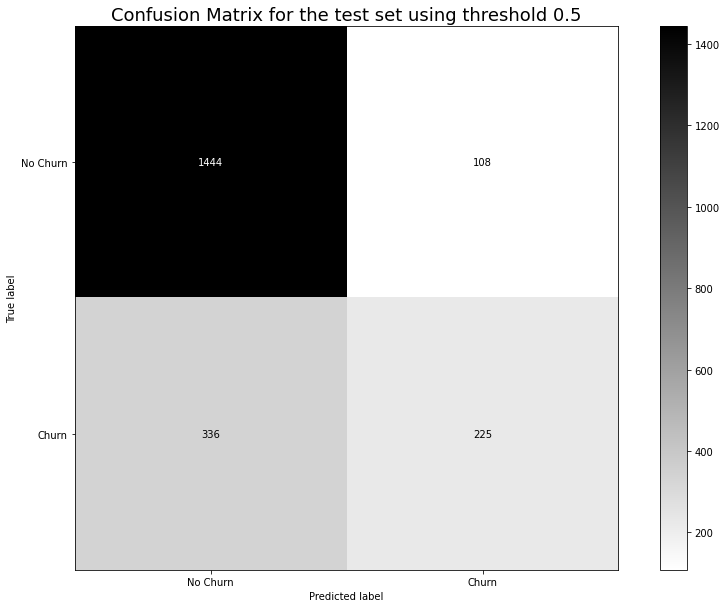

In [58]:
plot_confusion_matrix(forest_model, X_prep_test, y_test, display_labels = ['No Churn', 'Churn'], cmap  = 'binary')
plt.title("Confusion Matrix for the test set using threshold 0.5", fontsize = 18)
plt.show()

In [59]:
print("Accuracy, recall, precision, and kappa for the test set using threshold of 0.5:")
accuracy_table(0.5, forest_model, X_prep_test, y_test)

Accuracy, recall, precision, and kappa for the test set using threshold of 0.5:


,0
Accuracy,0.789872
Recall,0.401070
Specificity,0.930412
Kappa,0.380906


... So, to maximize recall, we can fiddle with the threshold level and lower it to 0.4 to be able to predict more churners. Now we are able to predict 63% of churners. Notice that true positive rate increased more than the false positive rate!

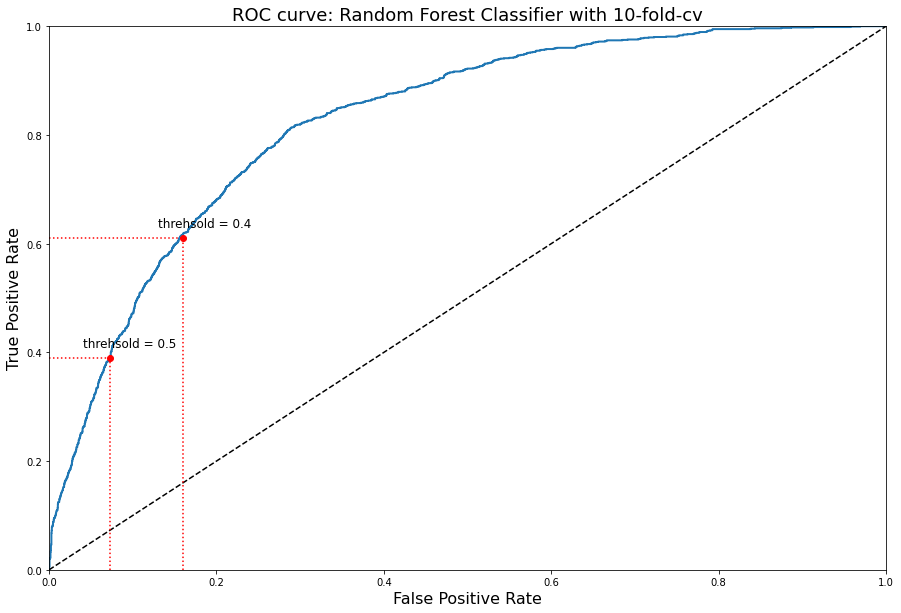

In [60]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict

y_scores = cross_val_predict(rnd_clf, X_prep, y_train, cv = 10, method = 'predict_proba')[:,1]

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    
plot_roc_curve(fpr, tpr)

# 0.5 threshold location
plt.plot([0.073, 0.073], [0., 0.39], "r:")
plt.plot([0.0, 0.073], [0.39, 0.39], "r:")
plt.plot([0.073], [0.39], "ro")
plt.text(0.04, 0.41, "threhsold = 0.5", fontsize = 12)

# 0.4 threshold location
plt.plot([0.16, 0.16], [0., 0.61], "r:")
plt.plot([0.0, 0.16], [0.61, 0.61], "r:")
plt.plot([0.16], [0.61], "ro")
plt.text(0.13, 0.63, "threhsold = 0.4", fontsize = 12)

plt.title('ROC curve: Random Forest Classifier with 10-fold-cv', fontsize = 18)

plt.show()

[]

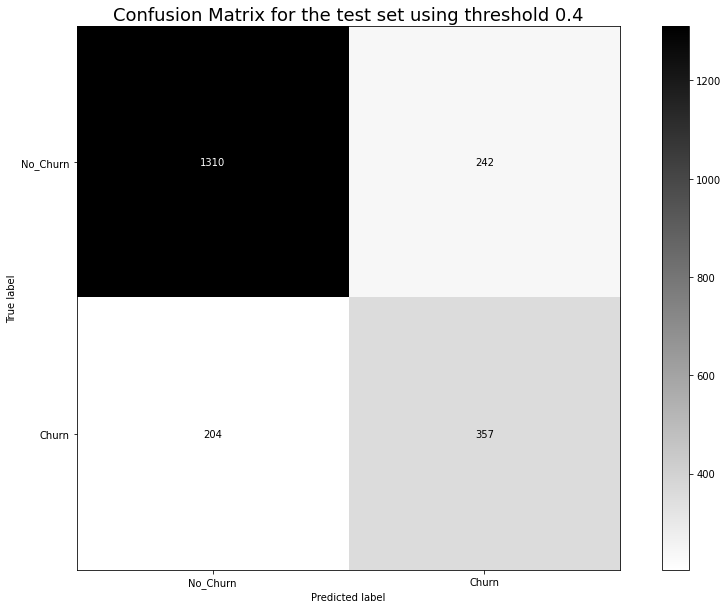

In [61]:
threshold = 0.4
predictions = np.where(forest_model.predict_proba(X_prep_test)[:,1] > threshold, 1, 0)

cm = confusion_matrix(y_test, predictions, labels = [0, 1])
display_labels = ['No_Churn', 'Churn']

disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels = display_labels)

disp = disp.plot(include_values = True, 
                 cmap = 'binary', 
                 ax = None, 
                 xticks_rotation = 'horizontal')
plt.title("Confusion Matrix for the test set using threshold 0.4", fontsize = 18)
plt.plot()

In [62]:
print("Accuracy, recall, precision, and kappa for the test set using threshold of 0.4:")
accuracy_table(threshold, forest_model, X_prep_test, y_test)

Accuracy, recall, precision, and kappa for the test set using threshold of 0.4:


,0
Accuracy,0.788926
Recall,0.636364
Specificity,0.844072
Kappa,0.470266


In [63]:
y_train_df = pd.DataFrame({'Churn': y_train[:]})

df_m = pd.merge(X_train, y_train_df, left_index = True, right_index = True)

df_m['margin'] = df_m['tenure']*20-60

more = df_m.loc[df_m['Churn'] == 0].mean()['margin'] - df_m.loc[df_m['Churn'] == 1].mean()['margin']

print("Total margin for customers grouped by churn. The figures are calculated based on the training set.")
df_m.groupby(by = "Churn").mean().iloc[:,[-1]]

Total margin for customers grouped by churn. The figures are calculated based on the training set.


,margin
Churn,
0,693.335174
1,294.204893


---

*The Bottom Line*

Looking at the recall figure, we expect to predict 64% of churners.

According to our training set, for every customer we can retain, we expect to make 399 USD more in total. Assuming marginal cost of 40 USD and marginal revenue of 60 USD and first month free.

Thus, the expected revenue gained from retaining a customer is around (399 X 0.64) ~ 250 USD if we have a 100% success rate and 0 retention costs. But we have to factor in the costs associated with retaining a customer and also a reasonable success rate in order to calculate the profit. 

We are imagining that offering a 3 month 50% discount could be a reasonable effort and half of all these who receive it will retain. Therefore, we expect to spend 30 USD more per customer and retain half, bringing our total profit to (250) X 0.5 - 30 = 95 USD. Well worth our efforts.

<IPython.core.display.Javascript object>


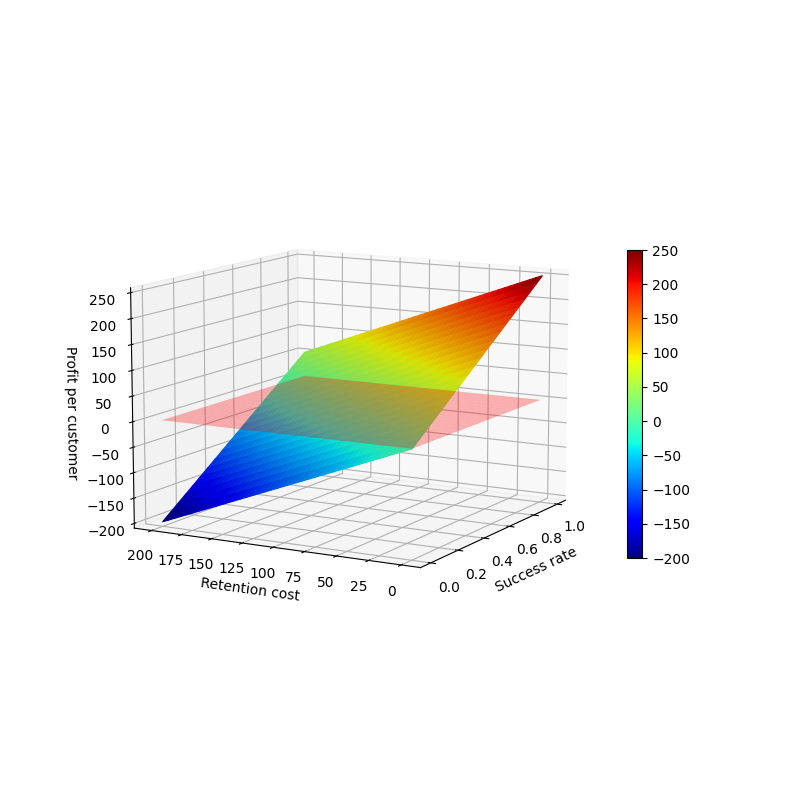

In [51]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['figure.figsize'] = [8, 8]

def fun(x, y):
    return x * (250) - y

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0, 1, 21)
y = np.linspace(0, 200, 41)

X, Y = np.meshgrid(x, y)
zs = np.array([fun(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)


norm = matplotlib.colors.Normalize(vmin=Z.min().min(), vmax=Z.max().max())
ax.plot_surface(X, Y, Z, facecolors = plt.cm.jet(norm(Z)), zorder = 0.3)

# plot also the surface where profit = 0
Z2 = np.zeros((X.shape))
ax.plot_surface(X, Y, Z2, alpha = 0.3, cmap = cm.autumn, zorder = 0.5)


ax.set_xlabel('Success rate')
ax.set_ylabel('Retention cost')
ax.set_zlabel('Profit per customer')

m = cm.ScalarMappable(cmap = plt.cm.jet, norm = norm)
m.set_array([Z])

plt.colorbar(m, shrink = 0.50)

plt.show()